**Involves 3 steps** -
1. **Resampling the audio data** - e.g change the sampling from 8 to 16kHz, upsampling using Nyquist sampling theorem is easier than downsampling wehich will create distortions in the signal called aliases. Downsampling correctly is tricky.

2. **Filtering the dataset** - 

3. **Converting audio data to model's expected input** -

In [7]:
# Load the MINDS-14 dataset
from datasets import load_dataset
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds[0]

Found cached dataset minds14 (C:/Users/Raj/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696)


{'path': 'C:\\Users\\Raj\\.cache\\huggingface\\datasets\\downloads\\extracted\\33db068c0127d574c944aa45170ab78a7d5079b92508e6a86d39e012cc006d49\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\Raj\\.cache\\huggingface\\datasets\\downloads\\extracted\\33db068c0127d574c944aa45170ab78a7d5079b92508e6a86d39e012cc006d49\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [8]:
# Resampling the MINDS-14 dataset to 16kHz from 8kHz
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16000))
minds


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [9]:
# Reload the first audio example and check the sampling rate
minds[0]

{'path': 'C:\\Users\\Raj\\.cache\\huggingface\\datasets\\downloads\\extracted\\33db068c0127d574c944aa45170ab78a7d5079b92508e6a86d39e012cc006d49\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\Raj\\.cache\\huggingface\\datasets\\downloads\\extracted\\33db068c0127d574c944aa45170ab78a7d5079b92508e6a86d39e012cc006d49\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

**Filtering the dataset** - using a criteria. One common case is to limit the audio examples to a certain duration

In [11]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_rang(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [12]:
# use librosa to get example's duration from the audio file
import librosa
new_column = [librosa.get_duration(filename=audio_file) for audio_file in minds["path"]]
minds = minds.add_column("duration", new_column)

# use hf datasets filter method to apply the filtering function
minds = minds.filter(is_audio_length_in_rang, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

C:\Users\Raj\AppData\Local\Temp\ipykernel_22492\3587941253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  new_column = [librosa.get_duration(filename=audio_file) for audio_file in minds["path"]]


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

**Preparing the data in the right format for model training**

_HF Transformers ofers a feature extractor class that can convert raw audio data into the input features the model expects_

_let's take a look at Whisper's feature extractor to understand some common feature extraction transformations_

**Whisper is a pre-trained model for Automatic Speech Recognition (ASR)**

1. Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s
2. Converts the padded audio arrays to log-mel Spectograms. Spectograms describe how the frequencies of a signal change over time experessed on mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing

In [15]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [16]:
# Write a function to preprocess a single audio example by passing it through the feature extractor
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [17]:
# apply the preprocessing function to the training examples using HF datasets map method
minds = minds.map(prepare_dataset)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

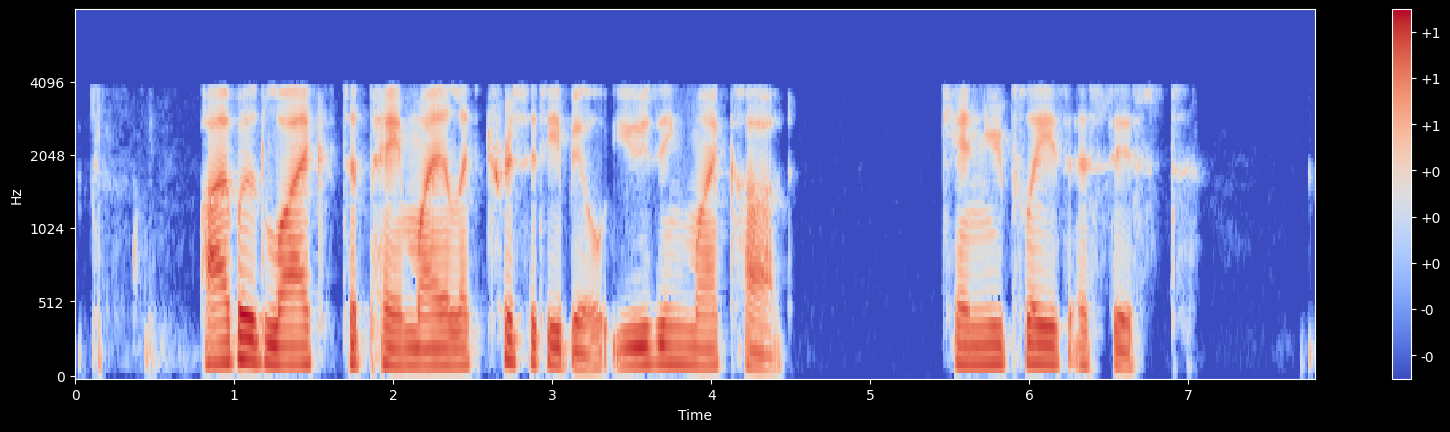

In [19]:
# Visualize the log-mel spectrogram of the first example
import matplotlib.pyplot as plt
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(20)
librosa.display.specshow(
    np.asarray(input_features[0]), 
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
    x_axis="time",
    y_axis="mel",
)
plt.colorbar(format="%+2.f")

In [20]:
# Use the AutoProcessor to load a model's feature extractor and processor from a checkpoint
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("openai/whisper-small")
processor

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-small', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftransc